# Predicting Pathogen from RNAseq data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pow
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC

random_state = 7

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer

patient_groups=["control", "viral", "bacterial"]#, "fungal"]
group_id = lambda name: patient_groups.index(name)

X = pd.DataFrame.from_csv("combineSV_WTcpmtable_v2.txt", sep="\s+").T
#    + [group_id("fungal")] * 10 \
y = [group_id("bacterial")] * 29 \
    + [group_id("viral")] * 42 \
    + [group_id("control")] * 61
    
#y = MultiLabelBinarizer().fit_transform([[i] for i in y])

fv = range(29+42, 29+42+10)
X = X.drop(X.index[fv])

print "Complete data set has %d samples and %d features." % (X.shape[0], X.shape[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=random_state, 
                                                    stratify=y)
print "Training set has %d samples. Testing set has %d samples." % (len(X_train), len(X_test))

Complete data set has 132 samples and 25342 features.
Training set has 105 samples. Testing set has 27 samples.


In [3]:
def print_gridsearch_results(clf):
    print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [4]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

#parameters={'estimator__C': [pow(2, i) for i in xrange(-25, 4, 1)]}
lr = LogisticRegression(class_weight="balanced", C=pow(2, -23))
#clf = RFE(estimator=lr, step=0.01, n_features_to_select=1, verbose=1)
clf = RFECV(cv=4, estimator=lr, n_jobs=6, scoring='f1_weighted', step=.001, verbose=0)
#clf = GridSearchCV(rfe, parameters, scoring='accuracy', n_jobs=8, cv=3, verbose=1)
clf.fit(X_train, y_train)
#print_gridsearch_results(clf)

/Users/matt/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matt/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matt/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matt/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RFECV(cv=4,
   estimator=LogisticRegression(C=1.19209289551e-07, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
   n_jobs=6, scoring='f1_weighted', step=0.001, verbose=0)

In [13]:
from IPython.core.display import display, HTML

rfe_features = []
for (rank, name) in zip(clf.ranking_, X.columns):
    if rank == 1:
        rfe_features.append(name)

s="""
<h2>List of %d genes found by RFE</h2>
<p>Note: the NCBI link will open the target in a new window or tab.</p>
<table>
""" % (clf.n_features_)

ncbi_url = lambda gene: "https://www.ncbi.nlm.nih.gov/gene/?term=%s[Gene Name] AND Human[Organism]" % (gene)

s += "<tr>"
for (i, gene) in enumerate(rfe_features):
    if not i % 10:
        s += "</tr><tr>"
    s += """
    <td><a target=\"_blank\" href=\"%s\">%s</a></td>
    """ %(ncbi_url(gene), gene)
s += "</tr></table>"

display(HTML(s))


A2M,ABL2,ACTB,ACTG1,ADAR,ADGRE1,ADRBK2,AGO1,AKAP13,ALDOA
ANXA5,AP2B1,APOB,ARF6,ARFGEF3,ARHGAP21,ARHGAP26,ATF6,ATP11A,ATXN2
B2M,B4GALT5,BIN2,BMS1,BNIP3L,BRE,C1orf21,C20orf194,CALM1,CALM3
CALR,CCDC168,CD74,CD96,CDC42BPA,CDR1,CEP250,CGN,CHP1,CLVS2
CNBP,CNTRL,COL16A1,CORO1A,CPD,CRKL,CSF2RB,CSPG4,CTSB,CXCL10
CXCL8,CXCR2,CYBB,DCN,DDX46,DIP2A,DSCAM,DSE,EEF1A1,EEF2
EFCAB14,EIF2AK2,EIF3A,EIF4G2,ELL2,EPB41L2,ERICH3-AS1,ETS1,EVI2B,EXOC7
EZR,FAM120A,FAM192A,FAT1,FBXL4,FCER1G,FTH1,FTL,FXR1,FYB
G3BP2,GAPDH,GAS7,GBP5,GFAP,GLUL,GNAI2,GNB2L1,GPBP1L1,GPX3
HDLBP,HIVEP1,HLA-DRA,HSP90AA1,HSPA8,IDS,IFI30,IFI44L,IFITM1,IFITM2
IFITM3,IL1B,IREB2,KCNQ1OT1,KIAA1109,KLF13,KMT2D,KPNA6,KRBA1,KSR2


Optimal number of features : 242
Recursive Feature Elimination (RFE) eliminated 25100 features


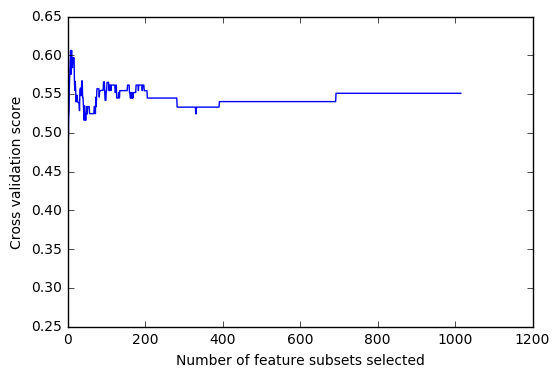

In [6]:
best_estimator = clf

print("Optimal number of features : %d" % best_estimator.n_features_)
print("Recursive Feature Elimination (RFE) eliminated %d features" % (X.shape[1] - best_estimator.n_features_))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of feature subsets selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(best_estimator.grid_scores_) + 1), best_estimator.grid_scores_)
plt.show()

None


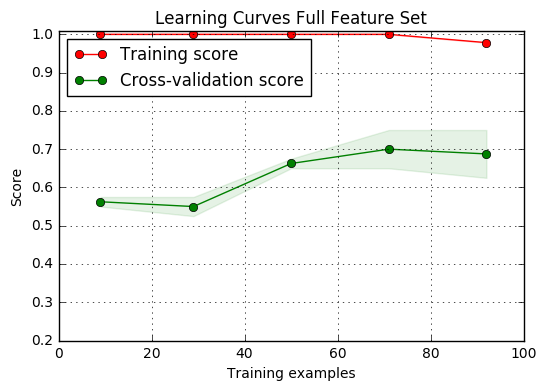

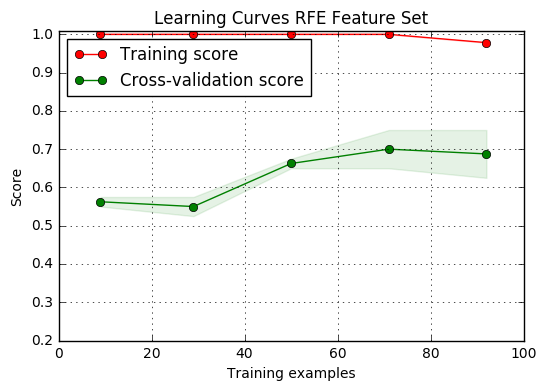

In [7]:
%matplotlib inline
from learning_curves import plot_learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

def create_learning_curve(title, model):
    cv = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=random_state)                                     
    plot_learning_curve(model, title, X, y, (0.2, 1.01), cv=cv, n_jobs=1)
    
create_learning_curve("Learning Curves Full Feature Set", lr)
create_learning_curve("Learning Curves RFE Feature Set", clf.estimator_)

plt.show()

## Make predictions based on the model

In [8]:
from classification_metrics import classification_metrics

lr.fit(X_train, y_train)
lr_predicted = lr.predict(X_test)
print "LR Full Metrics"
classification_metrics(y_test, lr_predicted, patient_groups)
rfe_predicted = clf.predict(X_test)
print "-" * 80
print "LR RFE Metrics"
classification_metrics(y_test, rfe_predicted, patient_groups)

LR Full Metrics
Accuracy was 66.67%

             precision    recall  f1-score   support

    control       0.70      0.58      0.64        12
      viral       0.71      0.56      0.63         9
  bacterial       0.60      1.00      0.75         6

avg / total       0.68      0.67      0.66        27

Confusion Matrix: cols = predictions, rows = actual

                       control          viral      bacterial
        control              7              2              3
          viral              3              5              1
      bacterial              0              0              6
--------------------------------------------------------------------------------
LR RFE Metrics
Accuracy was 70.37%

             precision    recall  f1-score   support

    control       0.78      0.58      0.67        12
      viral       0.75      0.67      0.71         9
  bacterial       0.60      1.00      0.75         6

avg / total       0.73      0.70      0.70        27

Confusion Mat

## Review model predictions

In [9]:
probs = pd.DataFrame(clf.predict_proba(X_test))
probstrs = lambda vals: ["%.2f" % (p*100) for p in vals]

d = {"Predicted": [patient_groups[i] for i in rfe_predicted],
     "Actual": [patient_groups[i] for i in y_test],
     "Prob. control": probstrs(probs[0]),
     "Prob. viral": probstrs(probs[1]),
     "Prob. bacteria": probstrs(probs[2])}

patient_df = pd.DataFrame(d, index=X_test.index)
patient_df.sort_values(by="Actual")

,Actual,Predicted,Prob. bacteria,Prob. control,Prob. viral
MN_223,bacterial,bacterial,62.14,0.00,37.85
MN_140,bacterial,bacterial,97.29,0.14,2.57
MN_304,bacterial,bacterial,77.56,9.72,12.71
MN_224,bacterial,bacterial,47.37,21.92,30.70
MN_324,bacterial,bacterial,87.90,12.09,0.00
MNC.473,bacterial,bacterial,66.97,25.73,7.30
MNC.571,control,control,1.94,73.58,24.47
MN_368,control,bacterial,93.97,5.77,0.25
MN_366,control,control,2.25,77.84,19.91
MNC.213,control,control,25.17,40.18,34.66


## Review patients the model misclassified

In [10]:
patient_df[patient_df["Predicted"] != patient_df["Actual"]]

,Actual,Predicted,Prob. bacteria,Prob. control,Prob. viral
MNC.054,control,viral,14.19,9.36,76.44
MNC.116,control,viral,18.25,3.32,78.43
MNC.033,viral,control,20.17,45.14,34.69
MNC.631,control,bacterial,99.61,0.34,0.05
MNC.291,control,bacterial,72.46,7.58,19.96
MNC.015,viral,bacterial,53.85,23.65,22.50
MNC.215,viral,control,0.60,65.73,33.68
MN_368,control,bacterial,93.97,5.77,0.25
